In [37]:
# Import
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier

In [38]:
# Load the Dataset
df = pd.read_csv("./../../Dataset/Final-dataset-binary/ultimatevocalremovergui.csv")

In [39]:
print(df.isnull().sum())

version           0
path              0
file_type         0
line_count        0
method_count      0
coupling_score    0
has_smell         0
dtype: int64


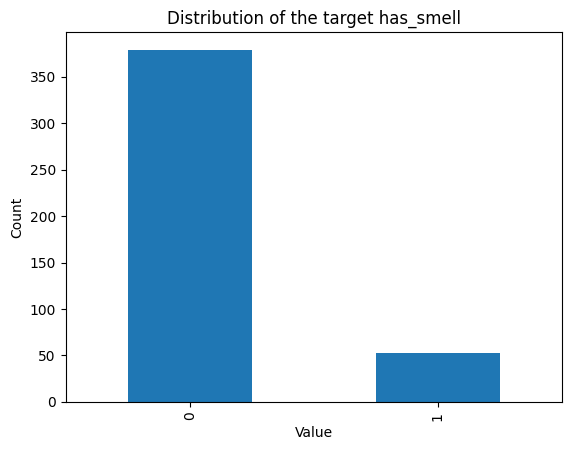

In [40]:
df["has_smell"].value_counts().plot(kind="bar")
plt.title("Distribution of the target has_smell")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [41]:
# Encoding categorical data
categorical_features = ["version", "path", "file_type"]
numerical_features = ["line_count", "method_count", "coupling_score"]
target_feature = "has_smell"

# Preprocessing
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = onehot_encoder.fit_transform(df[categorical_features])

X_num = df[numerical_features].values

X_combined = np.concatenate([X_cat, X_num], axis=1)
y = df[target_feature].values

In [42]:
# Splitting the dataset into the Training set and the Test set
split_idx = int(0.8 * len(df))
X_train, X_test = X_combined[:split_idx], X_combined[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [43]:
# Feature scaling
num_start = X_cat.shape[1]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# ANN Model

In [44]:
ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann_model.add(tf.keras.layers.Dropout(0.3))
ann_model.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann_model.add(tf.keras.layers.Dropout(0.3))
ann_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [45]:
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
ann_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[callback])

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3877 - loss: 0.9954 - val_accuracy: 0.5942 - val_loss: 0.6493
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7138 - loss: 0.5777 - val_accuracy: 0.6087 - val_loss: 0.6911
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8587 - loss: 0.4148 - val_accuracy: 0.5942 - val_loss: 0.8040
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9348 - loss: 0.3051 - val_accuracy: 0.5942 - val_loss: 0.9201
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9493 - loss: 0.2735 - val_accuracy: 0.5942 - val_loss: 1.0144
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9457 - loss: 0.2851 - val_accuracy: 0.5942 - val_loss: 1.0747
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9493 - loss: 0.2143 - val_accuracy: 0.5942 - val_loss: 1.0879
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9493 - loss: 0.2305 - val_accuracy: 0.5942 - val_loss: 1.1099

In [47]:
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype(int).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred_ann))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
print("Classification Report:\n", classification_report(y_test, y_pred_ann))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.5977011494252874
Confusion Matrix:
 [[47 28]
 [ 7  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73        75
           1       0.15      0.42      0.22        12

    accuracy                           0.60        87
   macro avg       0.51      0.52      0.48        87
weighted avg       0.77      0.60      0.66        87



# Random Forest Model

In [48]:
forest_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)

In [49]:
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_forest))
print("Classification Report:\n", classification_report(y_test, y_pred_forest))

Accuracy: 0.8735632183908046
Confusion Matrix:
 [[74  1]
 [10  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93        75
           1       0.67      0.17      0.27        12

    accuracy                           0.87        87
   macro avg       0.77      0.58      0.60        87
weighted avg       0.85      0.87      0.84        87



# Code Stacking (SVR)

In [50]:
# Créer les ebtrées du modèle d'ensemble (stacking)
ann_preds = ann_model.predict(X_test).flatten()
forest_preds = forest_model.predict(X_test)
stacked_inputs = np.column_stack((ann_preds, forest_preds))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [51]:
# Entrîner le modèle méta (SVR)
meta_model = SVR()
meta_model.fit(stacked_inputs, y_test)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [52]:
# Prédictions finales
final_preds = meta_model.predict(stacked_inputs)

In [53]:
# Evaluation
mse = mean_squared_error(y_test, final_preds)
print("MSE du modèle de stacking (SVR):", mse)
print("Prédictions (extrait):", final_preds[:10])

MSE du modèle de stacking (SVR): 0.10818192203827401
Prédictions (extrait): [0.09962889 0.08577402 0.08549627 0.0998027  0.09879708 0.09634855
 0.09921487 0.08812466 0.09773168 0.08541903]


In [54]:
final_preds_binary = (final_preds >= 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, final_preds_binary)
print("Accuracy stacking SVR :", accuracy)

# Evaluation complète
print("Confusing Maxtric:\n", confusion_matrix(y_test, final_preds_binary))
print("Classification Report:\n", classification_report(y_test, final_preds_binary))

Accuracy stacking SVR : 0.8735632183908046
Confusing Maxtric:
 [[74  1]
 [10  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93        75
           1       0.67      0.17      0.27        12

    accuracy                           0.87        87
   macro avg       0.77      0.58      0.60        87
weighted avg       0.85      0.87      0.84        87

